In [3]:
# Imports 
import matplotlib.pyplot as plt
import time

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import numpy as np
import librosa
import pandas as pd
import os

# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix


In [4]:
file_path = 'speakers_all.csv'
df = pd.read_csv(file_path)

min_samples = 100

language_counts = df["native_language"].value_counts()
valid_languages = language_counts[language_counts >= min_samples].index
df = df[df["native_language"].isin(valid_languages)]

df_majority = df[df["native_language"] == 'english']
df_minority = df[df["native_language"] != 'english']

majority_size = len(df_majority)
# majority_size = 160
df_majority = df_majority.sample(n=majority_size,random_state=42)

# df_minority = df_minority.sample(n=majority_size,random_state=42, replace=True)

df = pd.concat([df_majority,df_minority])

print("Class distribution after dropping low-count entries and rebalancing:")
print(df["native_language"].value_counts())



Class distribution after dropping low-count entries and rebalancing:
native_language
english    579
spanish    162
arabic     102
Name: count, dtype: int64


In [108]:
import os
import glob

AUDIO_DIR = "recordings" 
existing_files = glob.glob(AUDIO_DIR + "*/*")  

print(f"Total available files: {len(existing_files)}")

Total available files: 2138


In [110]:
def remove_silence(y, sr, top_db=25):
    """Remove silent segments from audio"""
    return librosa.effects.trim(y, top_db=top_db)[0]

def extract_mfcc(file_path, max_len=1000):
    if not os.path.exists(file_path):
        print(f"File not found - {file_path}")
        return None
    
    y, sr = librosa.load(file_path, sr=16000)
    y = remove_silence(y, sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), 
                       mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    
    scaler = StandardScaler()
    return scaler.fit_transform(mfcc.T)

features = []
labels = []

for i, (_, row) in enumerate(df.iterrows(), 1):
    file_path = os.path.join(AUDIO_DIR, row["filename"] + ".mp3")
    mfcc_features = extract_mfcc(file_path, max_len=1000)
    
    if mfcc_features is not None:
        features.append(mfcc_features)  # Still (500, 13)
        labels.append(row["native_language"])
        if i%10 == 0:
            print(f"Processed file {i}: {row['filename']}")

print(f"Final features shape: {np.array(features).shape}")  # (n_files, 500, 13)


Processed file 10: english162
Processed file 20: english443
Processed file 30: english577
Processed file 40: english173
Processed file 50: english552
Processed file 60: english198
Processed file 70: english239
Processed file 80: english170
Processed file 90: english566
Processed file 100: english23
Processed file 110: english483
Processed file 120: english387
Processed file 130: english179
Processed file 140: english380
Processed file 150: english413
Processed file 160: english148
Processed file 170: english414
Processed file 180: english322
Processed file 190: english540
Processed file 200: english482
Processed file 210: english474
Processed file 220: english212
Processed file 230: english470
Processed file 240: english91
Processed file 250: english40
Processed file 260: english347
Processed file 270: english301
Processed file 280: english521
Processed file 290: english273
Processed file 300: english79
Processed file 310: english83
Processed file 320: english399
Processed file 330: en

In [111]:
# Convert labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert to NumPy arrays
features = np.array(features, dtype=np.float32)
labels_encoded = np.array(labels_encoded, dtype=np.int64)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

In [112]:
class AccentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = AccentDataset(X_train_tensor, y_train_tensor)
test_dataset = AccentDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [113]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, 
                           num_layers=2,
                           batch_first=True,
                           dropout=0.3)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.bn(out)  # Apply batch norm
        out = self.dropout(out)
        return self.fc(out)

# Define model parameters
input_dim = 13
hidden_dim = 32
output_dim = len(label_encoder.classes_)
num_layers = 2




In [114]:
# Create model
model = SimpleLSTM(input_dim, hidden_dim, output_dim, num_layers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Basic cross with class weights
# class_weights = torch.tensor([1.0, 5.0, 5.0], device=device) 
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()  

optimizer = optim.Adam(model.parameters(), 
                      lr=0.001,
                      weight_decay=0.001)  # L2 regularization

num_epochs = 30

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
counter = 0
best_model_weights = None

train_losses = []
train_accuracies = []
test_accuracies = []
best_epoch = 0
all_true = []
all_preds = []

for epoch in range(num_epochs):
    start_time = time.time()  
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    # Training Loop
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct_train / total_train

    # Evaluation
    model.eval()
    val_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            val_loss += criterion(outputs,y_batch).item()
            correct_test += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)
            
            all_true.extend(y_batch.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss /= len(test_loader)
    test_acc = correct_test / total_test

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_weights = model.state_dict().copy()
        best_epoch = epoch
    else:
        counter += 1 
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            num_epochs = epoch
            break
            pass

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    epoch_time = time.time() - start_time  
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Time: {epoch_time:.2f}s")

if best_model_weights:
    model.load_state_dict(best_model_weights)


Epoch 1/30, Loss: 1.1286, Train Acc: 0.4060, Test Acc: 0.5905, Time: 8.44s
Epoch 2/30, Loss: 0.9698, Train Acc: 0.5605, Test Acc: 0.6121, Time: 8.86s
Epoch 3/30, Loss: 0.8758, Train Acc: 0.5950, Test Acc: 0.6422, Time: 12.17s
Epoch 4/30, Loss: 0.8369, Train Acc: 0.6382, Test Acc: 0.6379, Time: 14.33s
Epoch 5/30, Loss: 0.8124, Train Acc: 0.6458, Test Acc: 0.6293, Time: 23.14s
Epoch 6/30, Loss: 0.7831, Train Acc: 0.6685, Test Acc: 0.6595, Time: 27.18s
Epoch 7/30, Loss: 0.7737, Train Acc: 0.6760, Test Acc: 0.6638, Time: 18.85s
Epoch 8/30, Loss: 0.7606, Train Acc: 0.6695, Test Acc: 0.6724, Time: 29.24s
Epoch 9/30, Loss: 0.7387, Train Acc: 0.6847, Test Acc: 0.6897, Time: 23.06s
Epoch 10/30, Loss: 0.7323, Train Acc: 0.6847, Test Acc: 0.6509, Time: 26.28s
Epoch 11/30, Loss: 0.7308, Train Acc: 0.6901, Test Acc: 0.6638, Time: 22.03s
Epoch 12/30, Loss: 0.7097, Train Acc: 0.7117, Test Acc: 0.6552, Time: 22.78s
Epoch 13/30, Loss: 0.7046, Train Acc: 0.7192, Test Acc: 0.6810, Time: 24.52s
Epoch 14/3

In [1]:
model.eval()
english_label = label_encoder.transform(['english'])[0]

true_binary = []
pred_binary = []
correct = 0
total = 0
english_correct = 0
english_total = 0
non_english_correct = 0
non_english_total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        true_binary.extend((y_batch == english_label).cpu().numpy())
        pred_binary.extend((predicted == english_label).cpu().numpy())

        correct_mask = (predicted == y_batch)
        
        english_mask = (y_batch == english_label)
        english_correct += correct_mask[english_mask].sum().item()
        english_total += english_mask.sum().item()

        non_english_mask = ~english_mask
        non_english_correct += correct_mask[non_english_mask].sum().item()
        non_english_total += non_english_mask.sum().item()

        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

# Basic Accuracy
english_accuracy = english_correct / english_total
non_english_accuracy = non_english_correct / non_english_total
overall_accuracy = correct / total

print(f"Native Accuracy: {english_accuracy:.4f}")
print(f"Non-Native Accuracy: {non_english_accuracy:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

tn, fp, fn, tp = confusion_matrix(true_binary, pred_binary).ravel()

# Disparate Impact Ratio
positive_rate_english = tp / (tp + fn) 
positive_rate_non_english = fp / (fp + tn)
disparate_impact = positive_rate_non_english / positive_rate_english

# Demographic Parity Difference
demographic_parity_diff = abs(positive_rate_english - positive_rate_non_english)

print()

print(f"Disparate Impact Ratio: {disparate_impact:.3f}")
print(f"Demographic Parity Difference: {demographic_parity_diff:.3f}")

NameError: name 'model' is not defined

Results (Performed by adjusting values maually):

Unbalanced:

- Native Accuracy: 0.9646
- Non-Native Accuracy: 0.1250
- Overall Accuracy: 0.6864
- Disparate Impact Ratio: 0.666
- Demographic Parity Difference: 0.322

Balanced so English matches total size of non-english:

- Native Accuracy: 0.9286
- Non-Native Accuracy: 0.3000
- Overall Accuracy: 0.6321
- Disparate Impact Ratio: 0.431
- Demographic Parity Difference: 0.529

Balanced so English is no larger than second largest:

- Native Accuracy: 0.8649
- Non-Native Accuracy: 0.4583
- Overall Accuracy: 0.6353
- Disparate Impact Ratio: 0.289
- Demographic Parity Difference: 0.615

Class weights:

- Native Accuracy: 0.9558
- Non-Native Accuracy: 0.1071
- Overall Accuracy: 0.6746
- Disparate Impact Ratio: 0.878
- Demographic Parity Difference: 0.116

Dropout 0.5:

- Native Accuracy: 0.9646
- Non-Native Accuracy: 0.0893
- Overall Accuracy: 0.6746
- Disparate Impact Ratio: 0.759
- Demographic Parity Difference: 0.232

Upsampling:

- Native Accuracy: 0.8333
- Non-Native Accuracy: 0.5472
- Overall Accuracy: 0.7026
- Disparate Impact Ratio: 0.408
- Demographic Parity Difference: 0.494

Accuracy plot saved to plots/Native_disparity_accuracy_plot_english_579_upsampled.png


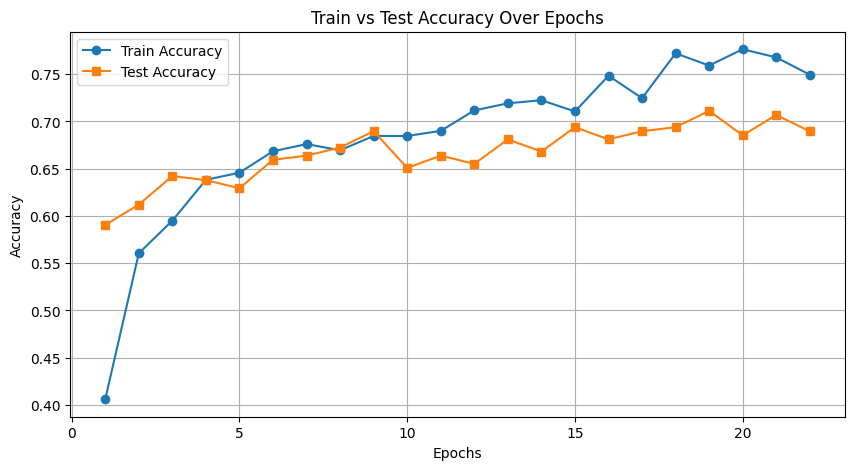

In [117]:

plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

# Plot train and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch+1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, epoch+1), test_accuracies, label="Test Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Over Epochs")
plt.legend()
plt.grid()

# Save the plot
plot_path = os.path.join(plot_dir, f"Native_disparity_accuracy_plot_english_{majority_size}_upsampled.png")
plt.savefig(plot_path, dpi=300) 
print(f"Accuracy plot saved to {plot_path}")
plt.show()


Accuracy plot saved to plots/Native_Disparity_confusion_plot_english_579_upsampled.png


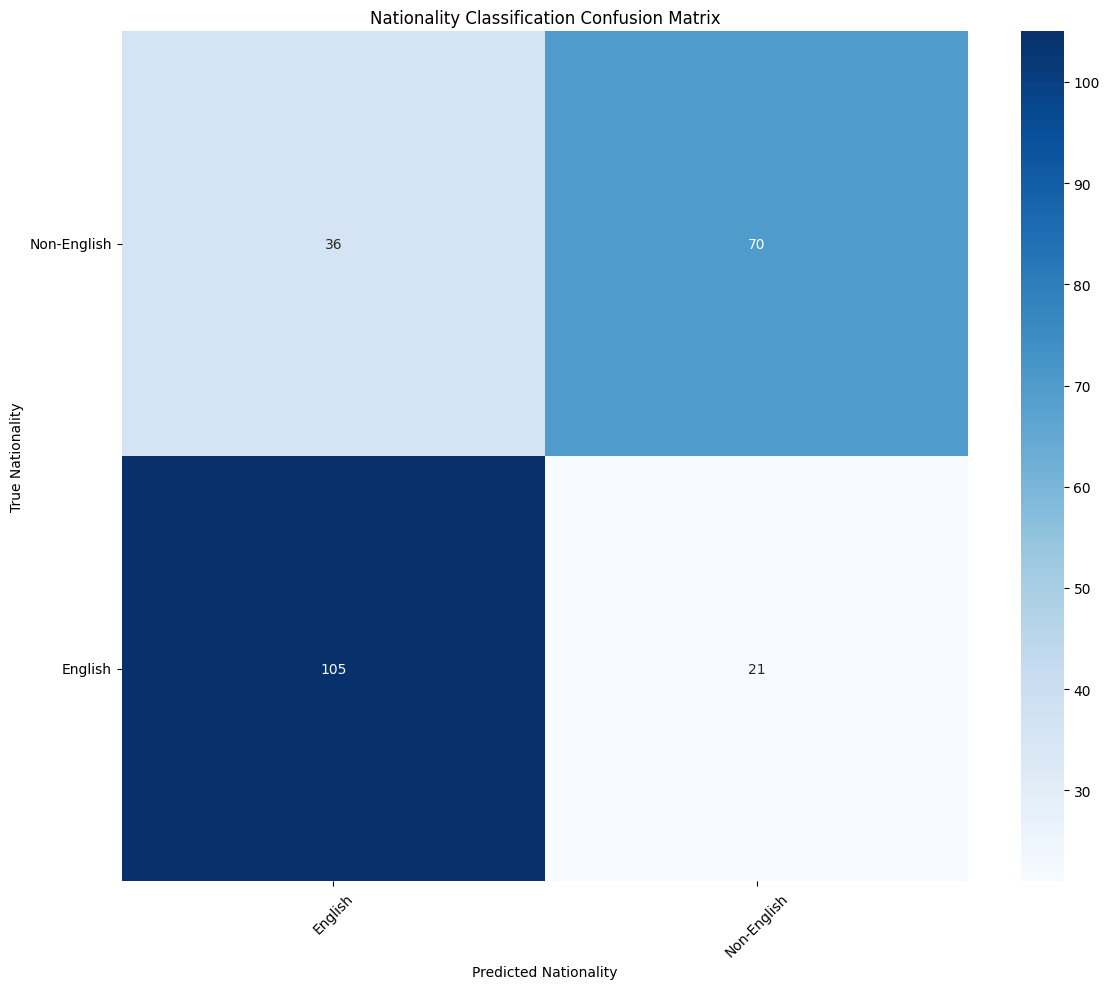

In [118]:

cm = confusion_matrix(true_binary, pred_binary)

cm_labels = ['Non-English','English'] 

# Plot
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=cm_labels,yticklabels=cm_labels)
plt.title('Nationality Classification Confusion Matrix')
plt.xlabel('Predicted Nationality')
plt.ylabel('True Nationality')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.gca().invert_xaxis()

# Save the plot
plot_path = os.path.join(plot_dir, f"Native_Disparity_confusion_plot_english_{majority_size}_upsampled.png")
plt.savefig(plot_path, dpi=300) 
print(f"Accuracy plot saved to {plot_path}")

plt.show()

